In [1]:
# Install required packages for the RAG system
%pip install -q langchain-ollama langchain langchain-community faiss-cpu langchain_huggingface rank_bm25 gradio nest_asyncio markdown2 ipywidgets langchain_openai

Note: you may need to restart the kernel to use updated packages.


## Chunks and Embedding loader 

In [1]:
import pickle
import os
from typing import List
from langchain.schema import Document


def load_chunks_from_disk(chunks_path: str) -> List[Document]:
    """
    Load document chunks from disk.
    
    Args:
        chunks_path: Path to the saved chunks file
        
    Returns:
        List of document chunks
    """
    print(f"\nLoading chunks from {chunks_path}...")
    
    # Check if file exists
    if not os.path.exists(chunks_path):
        raise FileNotFoundError(f"Chunks file not found at {chunks_path}")
    
    # Load the chunks from disk
    with open(chunks_path, "rb") as f:
        chunks = pickle.load(f)
    
    print(f"Loaded {len(chunks)} chunks from disk")
    return chunks

In [2]:
# Initialize embedding model and load vector store
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# Load embedding model
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Load pre-existing vector store
loaded_faiss_store = FAISS.load_local(
    "/workspaces/RAG_BOT/LocalEmbeddings/Chatgpt_Enriched_Policy_Only_Embedding",
    embedding_model,
    allow_dangerous_deserialization=True
)
print("FAISS vector store loaded successfully.")

# Load the chunks also
chunks = load_chunks_from_disk("/workspaces/RAG_BOT/LocalChunks/document_chunks_20250715_020245.pkl")


FAISS vector store loaded successfully.

Loading chunks from /workspaces/RAG_BOT/LocalChunks/document_chunks_20250715_020245.pkl...
Loaded 58 chunks from disk


## LLM Configuration

In [3]:
# Initialize the LLM with rate limiting
from langchain_ollama import ChatOllama
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_openai import ChatOpenAI
from getpass import getpass

# Configure rate limiting to prevent overloading the model
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.1,
    check_every_n_seconds=0.1,
    max_bucket_size=10,
)

openai_api_key = getpass("Enter your OpenAI API key: ")

# Initialize the LLM
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    openai_api_key = openai_api_key,
    temperature=0.1,
    rate_limiter=rate_limiter
)


# Retrival Method-1  ensemble

In [4]:
# Set up retrievers
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever

# Extract documents from the docstore
try:
    all_docs = [loaded_faiss_store.docstore._dict[doc_id] for doc_id in loaded_faiss_store.index_to_docstore_id.values()]
except AttributeError:
    # Fallback for different docstore structure
    all_docs = [loaded_faiss_store.docstore.get(doc_id) for doc_id in loaded_faiss_store.index_to_docstore_id.values()]

# Configure different retrieval methods
bm25_retriever = BM25Retriever.from_documents(all_docs)
bm25_retriever.k = 2

# Vector similarity retrieval with MMR
basic_retriever = loaded_faiss_store.as_retriever(search_type="mmr", search_kwargs={"k": 2})

# Vector similarity with score threshold
sst_retriever = loaded_faiss_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"score_threshold": 0.3, "k": 2}
)

# Create ensemble retriever combining multiple retrieval methods
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, basic_retriever, sst_retriever],
    weights=[0.4, 0.3, 0.3]
)

In [5]:
# Set up prompt templates
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

# Define system instructions for the model
SYSTEM_PROMPT = """
You are a highly knowledgeable and helpful CyberArk API documentation assistant. Your primary role is to answer developer questions accurately and clearly, *using only the provided API documentation context*.

**GENERAL RULES FOR ALL RESPONSES:**
1.  **Context Reliance:** Answer *ONLY* based on the provided "Documentation Context". Do not use external knowledge or invent information.
2.  **Handling Missing Information:** If the answer to the user's question is not explicitly found within the provided documentation context, politely state: "I don't have that specific information in the documentation I can access." Do NOT guess or invent details.
3.  **Markdown Formatting:** Always use Markdown for structuring your answers (headers, code blocks, bullet points, etc.) to enhance readability.


**SPECIFIC RESPONSE BEHAVIORS:**

* **IF the user input is a general greeting (e.g., "hello", "hi", "hey"):**
    * Respond politely as a friendly assistant.
    * Example: "Hello! I'm your CyberArk API assistant. How can I help you with the CyberArk API today?"

* **ELSE IF the user is asking about a specific API endpoint:**
    * Provide detailed endpoint information. This should include:
        * Path and HTTP method (GET, POST, PUT, DELETE)
        * Required parameters (query, path, body)
        * Security requirements
        * Request body schema (in JSON if available)
        * Response body schema (in JSON if available)
        * Any available sample requests and responses.
    * Format your response with markdown, using headers for sections and code blocks for JSON examples.

* **ELSE IF the user is asking a general question about CyberArk API functionality (not tied to a single endpoint):**
    * Answer based ONLY on the provided context.
    * Try to be clear, concise, informative and straight to the point.
    * Include relevant code examples only if it is asked in query.

* **ELSE IF the Documentation Context is not available or question is outside the scope of CyberArk API documentation:**
    * Politely state: "I'm specialized in CyberArk API documentation. I don't have information about that topic in my knowledge base."
"""


system_message = SystemMessagePromptTemplate.from_template(SYSTEM_PROMPT)

# Define how user questions and context are formatted
human_message = HumanMessagePromptTemplate.from_template(
    """
You are answering questions about CyberArk's API. Use the documentation context

Documentation Context:
----------------------
{context}

New User Question:
----------------------
{question}
"""
)


In [6]:
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from typing import List, Tuple, Optional
import time

def get_answer(query: str):
    
    # Skip retrieval for simple greetings
    greeting_terms = ["hello", "hi", "hey", "greetings"]
    is_greeting = any(term in query.lower() for term in greeting_terms) and len(query.split()) < 4
    
    if is_greeting:
        # Direct response for greetings without using retrieval
        response = "Hello! I'm your CyberArk API assistant. How can I help you with the CyberArk API today?"
    else:
        # Create a retrieval chain that combines context and chat history
        retrieval_chain = RunnableParallel(
            {"context": ensemble_retriever, "question": RunnablePassthrough()}
        )
        
        # Execute retrieval
        retrieval_output = retrieval_chain.invoke(query)
        
        # Format the retrieved documents into a single context string
        context_docs = retrieval_output["context"]
        context_text = "\n\n".join([doc.page_content for doc in context_docs])
        
        # Create the complete prompt
        chat_prompt = ChatPromptTemplate.from_messages([
            system_message,
            HumanMessagePromptTemplate.from_template(
                """
                You are answering questions about CyberArk's API. Use the documentation context

                Documentation Context:
                ----------------------
                {context}

                New User Question:
                ----------------------
                {question}
                """
            )
        ])
        
        # Create and execute the generation chain
        generation_chain = chat_prompt | llm
        
        # Add rate limiting to prevent API overload
        time.sleep(0.5)  # Simple rate limiting
        
        # Generate response
        response = generation_chain.invoke({
            "context": context_text,
            "question": query
        })
        
        # Extract the content from the response
        if hasattr(response, 'content'):
            response = response.content
    
    return response

# Retrieval Method-2 Neighbourhood Expansion

In [7]:
def find_common_documents(docs1, docs2):
    """
    Find common documents between two document arrays based on doc_index and chunk_index in metadata.
    If nothing is common, return the top document from each array.
    
    Args:
        docs1: First array of documents
        docs2: Second array of documents
        
    Returns:
        List of common documents or top documents if nothing in common
    """
    # Handle empty array scenarios
    if not docs1 and not docs2:
        return []
    if not docs1:
        return [docs2[0]] if docs2 else []
    if not docs2:
        return [docs1[0]] if docs1 else []
    
    # Create a set of (doc_index, chunk_index) tuples from the first array for faster lookups
    doc_identifiers = {(doc.metadata.get('doc_index'), doc.metadata.get('chunk_index')) 
                      for doc in docs1 
                      if 'doc_index' in doc.metadata and 'chunk_index' in doc.metadata}
    
    # Find common documents based on doc_index and chunk_index
    common_docs = [doc for doc in docs2 
                  if 'doc_index' in doc.metadata and 'chunk_index' in doc.metadata and
                  (doc.metadata.get('doc_index'), doc.metadata.get('chunk_index')) in doc_identifiers]
    
    # If no common documents, take top document from each array
    if not common_docs:
        return [docs1[0], docs2[0]]
    
    return common_docs


In [8]:
from typing import List, Dict, Any

def get_adjacent_docs(chunks: List[Document], doc_index: int, chunk_index_in_doc: int, doc_name: str, n: int = 1, debug = False) -> Dict[str, Any]:
    """
    Get a specific chunk and its adjacent chunks within the same document.
    
    Args:
        chunks: List of all document chunks
        doc_index: Index of the document
        chunk_index_in_doc: Index of the chunk within the document
        n: Number of adjacent chunks to retrieve in each direction (default: 1)
    
    Returns:
        Dictionary containing the current chunk and lists of previous and next chunks
    """
    # Find all chunks from the specified document
    doc_chunks = [
        chunk for chunk in chunks 
        if chunk.metadata.get("doc_index") == doc_index and
        chunk.metadata.get("doc_name") == doc_name
    ]
    
    if not doc_chunks:
        raise ValueError(f"No chunks found for document index {doc_index}")
    
    # Sort chunks by their position in the document
    doc_chunks.sort(key=lambda x: x.metadata.get("chunk_index"))
    
    # Find the specified chunk within the document chunks
    target_chunk = None
    current_position = -1
    
    for i, chunk in enumerate(doc_chunks):
        if chunk.metadata.get("chunk_index") == chunk_index_in_doc:
            target_chunk = chunk
            current_position = i
            break
    
    if current_position == -1:
        raise ValueError(f"Chunk with index {chunk_index_in_doc} not found in document {doc_index}")
    
    if debug:
        print(f"\nRetrieving adjacent chunks for document {doc_index}:")
        print(f"  Document name: {target_chunk.metadata.get('doc_name', 'Unknown')}")
        print(f"  Chunk position within document: {chunk_index_in_doc + 1} of {target_chunk.metadata.get('total_chunks_in_doc', 'Unknown')}")
        print(f"  Retrieving {n} chunks before and after")
    
    # Get previous n chunks (if available)
    prev_chunks = []
    start_idx = max(0, current_position - n)
    if start_idx < current_position:
        prev_chunks = doc_chunks[start_idx:current_position]
    
    # Get next n chunks (if available)
    next_chunks = []
    end_idx = min(len(doc_chunks), current_position + n + 1)
    if current_position + 1 < end_idx:
        next_chunks = doc_chunks[current_position + 1:end_idx]
    
    print(f"  Found {len(prev_chunks)} previous chunks and {len(next_chunks)} next chunks")
    
    return {
        "current_chunk": target_chunk,
        "prev_chunks": prev_chunks,
        "next_chunks": next_chunks,
        "all_doc_chunks": doc_chunks
    }

In [9]:

# Implement the neighborhood expansion retrieval method
def retrieve_docs_with_neighborhood_expansion(query):
    """
    Retrieve documents using both similarity and BM25 methods, then find common documents.
    This implements a form of 'neighborhood expansion' by combining multiple retrieval methods.
    
    Args:
        query: User query string
        
    Returns:
        List of relevant documents
    """

    # RETRIEVERS USED WITH THE FLOW
    similarity_docs = sst_retriever.invoke(query)
    bm25_docs = bm25_retriever.invoke(query)
    
    # Find common or top documents
    relevant_docs = find_common_documents(similarity_docs, bm25_docs)

    final_expanded_docs = []
    # Get the neighbourhood expansion
    if len(relevant_docs)>0:
        for doc in relevant_docs:
            chunk_index = doc.metadata.get('chunk_index')
            doc_index = doc.metadata.get('doc_index')
            doc_name = doc.metadata.get('doc_name')
            response = get_adjacent_docs(chunks, doc_index, chunk_index,doc_name, n=2)
            expanded_docs = response["prev_chunks"] + [response["current_chunk"]] + response["next_chunks"]
            final_expanded_docs.extend(expanded_docs) 
    return final_expanded_docs

In [10]:
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from typing import List, Tuple, Optional
import time
from IPython.display import display, Markdown, Latex


def get_answer_using_neighbourhood(query: str, debug=False):
    """
    Retrieve documents and generate a response with neighborhood expansion.
    
    Args:
        query: User question
        debug: Whether to print the final prompt for debugging (default: True)
        
    Returns:
        Response from the LLM
    """
    # Skip retrieval for simple greetings
    greeting_terms = ["hello", "hi", "hey", "greetings"]
    is_greeting = any(term in query.lower() for term in greeting_terms) and len(query.split()) < 4
    
    if is_greeting:
        # Direct response for greetings without using retrieval
        response = "Hello! I'm your CyberArk API assistant. How can I help you with the CyberArk API today?"
    else:
        # Format the retrieved documents into a single context string
        context_docs = retrieve_docs_with_neighborhood_expansion(query)
        context_text = "\n\n".join([doc.page_content for doc in context_docs])

        print(f"\nRetrieved {len(context_docs)} relevant documents for the query: '{query}'")
        
        # Create the complete prompt
        chat_prompt = ChatPromptTemplate.from_messages([
            system_message,
            HumanMessagePromptTemplate.from_template(
            """
            You are answering questions about CyberArk's API. Use the documentation context

            Documentation Context:
            ----------------------
            {context}

            New User Question:
            ----------------------
            {question}
            """
            )
        ])
        
        ######################## ONLY FOR DEBUGGING #######################################
        # Format the prompt with actual values to print it
        if debug:
            # Get the messages with variables filled in
            formatted_messages = chat_prompt.format_messages(
                context=context_text,
                question=query
            )
            
            # Print the complete formatted prompt 
            print("\n===== FINAL PROMPT SENT TO LLM =====")
            for i, message in enumerate(formatted_messages):
                role = message.type
                content = message.content
                print(f"\n--- Message {i+1} ({role}) ---")
                print(content)
            print("\n====================================")
        
        # Create and execute the generation chain
        generation_chain = chat_prompt | llm
        
        # Add rate limiting to prevent API overload
        time.sleep(0.5)  # Simple rate limiting
        
        # Generate response
        response = generation_chain.invoke({
            "context": context_text,
            "question": query
        })
        
        # Extract the content from the response
        if hasattr(response, 'content'):
            response = response.content
    
    return response


# LLM JUDGE

In [11]:
import json


with open("/workspaces/RAG_BOT/Truths/Questions_Sample.json") as f:
    questions = json.load(f)

print(f"Loaded {len(questions)} evaluation questions.")

Loaded 30 evaluation questions.


In [13]:
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from langchain_core.prompts import PromptTemplate

def evaluate_with_llm_judge(question, reference_answer, generated_answer):
    """
    Use the LLM to evaluate a generated answer against a reference answer.
    
    Args:
        question: The original question
        reference_answer: The ground truth answer
        generated_answer: The answer generated by the retrieval method
        
    Returns:
        JSON response with scores and feedback
    """
    # Create the prompt for the LLM judge
    judge_prompt = PromptTemplate.from_template("""
        You are an impartial judge evaluating the quality of answers provided by a chatbot based on a given reference answer. Your goal is to provide a comprehensive and fair assessment, focusing on accuracy, completeness, conciseness, clarity, adherence to instructions, and overall relevance.

            You will be given:

            1. **Question:** {QUESTION}
            2. **Reference Answer:** {REFERENCE_ANSWER}
            3. **Generated Answer:** {GENERATED_ANSWER}

            Your task is to compare the generated answer against the reference answer and assign scores based on the following criteria. Each score should be an integer from 1 to 5, where 1 is "Poor" and 5 is "Excellent".

            ---

            **Evaluation Criteria:**

            * **Accuracy (Score 1-5):**
                * How factually correct is the generated answer compared to the reference answer?
                * Does it contain any incorrect information or hallucinations?
                * Does it correctly interpret the intent of the question?
                * Score 1: Contains significant factual errors or hallucinations.
                * Score 2: Contains minor factual errors or some misinterpretations.
                * Score 3: Mostly accurate, but may have slight inaccuracies or omissions.
                * Score 4: Highly accurate, with no factual errors.
                * Score 5: Perfectly accurate and precise.

            * **Completeness (Score 1-5):**
                * Does the generated answer cover all the essential points and details present in the reference answer?
                * Does it omit any crucial information?
                * Score 1: Misses most essential information.
                * Score 2: Misses several key points.
                * Score 3: Covers most key points, but might omit some minor details.
                * Score 4: Covers almost all essential points comprehensively.
                * Score 5: Fully covers all essential points and details.

            * **Conciseness (Score 1-5):**
                * Is the generated answer to the point and free of unnecessary verbosity or repetition?
                * Does it provide relevant information without excessive preamble or redundant phrasing?
                * Score 1: Extremely verbose, repetitive, or contains irrelevant information.
                * Score 2: Noticeably verbose or somewhat repetitive.
                * Score 3: Generally concise, but could be slightly tighter.
                * Score 4: Concise and to the point.
                * Score 5: Perfectly concise and efficient.

            * **Clarity & Readability (Score 1-5):**
                * Is the generated answer easy to understand and well-structured?
                * Is the language clear, and is the formatting appropriate (e.g., use of bullet points, code blocks, bolding if applicable)?
                * Score 1: Difficult to understand, poorly structured, or confusing.
                * Score 2: Some parts are unclear or structure is lacking.
                * Score 3: Generally clear, but could be better organized or phrased.
                * Score 4: Clear, well-organized, and easy to read.
                * Score 5: Exceptionally clear, well-structured, and highly readable.

            * **Adherence to Instructions (Score 1-5):**
                * Does the generated answer follow any specific formatting rules or constraints (e.g., citation format, JSON structure if applicable for the chatbot's task, *not* inventing details, etc.)?
                * Does it correctly cite sources where required?
                * Score 1: Fails to follow most key instructions or violates major constraints.
                * Score 2: Fails to follow several instructions or has significant deviations.
                * Score 3: Follows most instructions, but has some minor deviations.
                * Score 4: Follows almost all instructions correctly.
                * Score 5: Perfectly adheres to all specified instructions.

            * **Relevance to Expected Answer (Score 1-5):**
                * How well does the generated answer match the *meaning*, *intent*, and *scope* of the reference answer?
                * Does it address the same core question in a way that is meaningfully equivalent?
                * Score 1: Entirely off-topic or unrelated to reference answer.
                * Score 2: Weak relevance, only partially addresses the expected content.
                * Score 3: Moderately relevant, but misses some key intent or scope.
                * Score 4: Strongly relevant, very close match to intent and scope.
                * Score 5: Perfectly relevant, fully equivalent in meaning and intent.

            ---

            **Output Format:**

            Your output must be a JSON object with the following structure:

            ```json
            {{
                "scores": {{
                    "accuracy": <score_1_5>,
                    "completeness": <score_1_5>,
                    "conciseness": <score_1_5>,
                    "clarity_readability": <score_1_5>,
                    "adherence_to_instructions": <score_1_5>,
                    "relevance_to_expected_answer": <score_1_5>
                }},
                "feedback": {{
                    "accuracy_notes": "<brief explanation for accuracy score, especially if not 5>",
                    "completeness_notes": "<brief explanation for completeness score, especially if not 5>",
                    "conciseness_notes": "<brief explanation for conciseness score, especially if not 5>",
                    "clarity_readability_notes": "<brief explanation for clarity & readability score, especially if not 5>",
                    "adherence_to_instructions_notes": "<brief explanation for adherence score, especially if not 5>",
                    "relevance_to_expected_answer_notes": "<brief explanation for relevance score, especially if not 5>",
                    "overall_summary": "<brief overall assessment of the generated answer, highlighting strengths and weaknesses>"
                }}
            }}
            ```
          
""")

    # Generate evaluation response
    generation_chain = judge_prompt | llm
    evaluation_response = generation_chain.invoke({
        "QUESTION": question,
        "REFERENCE_ANSWER": reference_answer,
        "GENERATED_ANSWER": generated_answer
    })
    
    # Extract content if using ChatOpenAI
    if hasattr(evaluation_response, 'content'):
        evaluation_response = evaluation_response.content

    # Parse the JSON response
    try:
        # Remove markdown code block markers if present
        evaluation_response = evaluation_response.replace("```json", "").replace("```", "").strip()
        evaluation_json = json.loads(evaluation_response)
        return evaluation_json
    except json.JSONDecodeError:
        print('----------- ERROR -------------')
        print(f"Error parsing JSON from LLM response. Raw response:\n{evaluation_response}")
        # Return a placeholder with error information
        return {
            "scores": {
                "accuracy": 0,
                "completeness": 0,
                "conciseness": 0,
                "clarity_readability": 0,
                "adherence_to_instructions": 0,
                "relevance_to_expected_answer": 0
            },
            "feedback": {
                "overall_summary": "Error parsing LLM response"
            },
            "raw_response": evaluation_response
        }
# evaluate_with_llm_judge("Which endpoint is used to delete an authentication profile?", "POST to /AuthProfile/DeleteProfile.", "call /Delete/policy")



In [14]:
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

def run_evaluation_parallel(questions, methods_dict, num_samples=None, max_workers=4):
    """
    Run evaluation on questions in parallel using multiple threads.
    
    Args:
        questions: List of question objects with category, question, answer, and difficulty
        methods_dict: Dictionary mapping method names to functions that take a question and return an answer
        num_samples: Optional number of questions to sample (for testing)
        max_workers: Maximum number of parallel workers (threads)
        
    Returns:
        DataFrame with all evaluation results
    """
    # Optionally sample a subset of questions
    if num_samples and num_samples < len(questions):
        import random
        sampled_questions = random.sample(questions, num_samples)
    else:
        sampled_questions = questions
    
    # Initialize a list to store all results (will be accessed by multiple threads)
    results = []
    
    # Create a lock to protect the results list during updates
    import threading
    results_lock = threading.Lock()
    
    # Function to process a single question (will be called in parallel)
    def process_question(question_data):
        i, q = question_data
        question_text = q["question"]
        reference_answer = q["answer"]
        category = q["category"]
        difficulty = q["difficulty"]
        
        question_results = []
        
        try:
            print(f"\nEvaluating question {i+1}/{len(sampled_questions)}")
            print(f"Category: {category}, Difficulty: {difficulty}")
            print(f"Question: {question_text}")
            
            # Get answers from all methods
            method_answers = {}
            
            # Generate answers from each method
            for method_name, method_func in methods_dict.items():
                print(f"\nGenerating answer with {method_name} for question {i+1}...")
                method_answers[method_name] = method_func(question_text)
            
            # Evaluate each method
            for method_name, answer in method_answers.items():
                print(f"\nEvaluating {method_name} answer for question {i+1}...")
                evaluation = evaluate_with_llm_judge(
                    question_text, reference_answer, answer
                )
                
                # Create a result dictionary
                result = {
                    "question_id": i,
                    "question": question_text,
                    "reference_answer": reference_answer,
                    "category": category,
                    "difficulty": difficulty,
                    "method": method_name,
                    "generated_answer": answer,
                    # Keep the original nested dictionaries for backward compatibility
                    "scores": evaluation.get("scores", {}),
                    "feedback": evaluation.get("feedback", {})
                }
                
                # Add individual score fields
                scores = evaluation.get("scores", {})
                for score_key in ["accuracy", "completeness", "conciseness", "clarity_readability", 
                                "adherence_to_instructions", "relevance_to_expected_answer"]:
                    result[f"score_{score_key}"] = scores.get(score_key, 0)
                
                # Add individual feedback fields
                feedback = evaluation.get("feedback", {})
                for feedback_key in ["accuracy_notes", "completeness_notes", "conciseness_notes", 
                                    "clarity_readability_notes", "adherence_to_instructions_notes", 
                                    "relevance_to_expected_answer_notes", "overall_summary"]:
                    result[f"feedback_{feedback_key}"] = feedback.get(feedback_key, "")
                
                question_results.append(result)
            
            # Save the results from this question
            with results_lock:
                results.extend(question_results)
                # Save intermediate results after each question
                interim_df = pd.DataFrame(results)
                interim_df.to_json("evaluation_results_interim.json", orient="records", indent=2)
                
            return True, i
            
        except Exception as e:
            print(f"Error processing question {i+1}: {e}")
            return False, i
    
    # Create a thread pool and process questions in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all questions to the executor
        future_to_question = {
            executor.submit(process_question, (i, q)): (i, q) 
            for i, q in enumerate(sampled_questions)
        }
        
        # Process results as they complete
        for future in concurrent.futures.as_completed(future_to_question):
            i, q = future_to_question[future]
            try:
                success, question_id = future.result()
                if success:
                    print(f"✅ Question {question_id+1} completed successfully")
                else:
                    print(f"❌ Question {question_id+1} failed")
            except Exception as e:
                print(f"❌ Question {i+1} generated an exception: {e}")
    
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    # Save the full results
    results_df.to_json("evaluation_results_final.json", orient="records", indent=2)
    
    return results_df

In [ ]:
results_df = run_evaluation_parallel(questions, 
                   {"Simple_Ensemble_Retriever": get_answer,
                    "Neighbourhood_Expansion" : get_answer_using_neighbourhood}, num_samples=10)



Evaluating question 1/10
Category: Conditional/branching logic, Difficulty: hard
Question: What would happen if you attempted to update a policy block without including RevStamp?

Generating answer with Simple_Ensemble_Retriever for question 1...

Evaluating question 2/10
Category: Conditional/branching logic, Difficulty: medium
Question: When saving a policy block with SavePolicyBlock3, when is RevStamp required?

Generating answer with Simple_Ensemble_Retriever for question 2...

Evaluating question 3/10
Category: Error handling / failure scenarios, Difficulty: easy
Question: What might cause /Policy/DeletePolicyBlock to fail?

Generating answer with Simple_Ensemble_Retriever for question 3...

Evaluating question 4/10
Category: Concurrency handling, Difficulty: medium
Question: Why does SavePolicyBlock3 include RevStamp?

Generating answer with Simple_Ensemble_Retriever for question 4...


No relevant docs were retrieved using the relevance score threshold 0.3



Generating answer with Neighbourhood_Expansion for question 3...
  Found 1 previous chunks and 2 next chunks

Retrieved 4 relevant documents for the query: 'What might cause /Policy/DeletePolicyBlock to fail?'

Generating answer with Neighbourhood_Expansion for question 1...
  Found 0 previous chunks and 2 next chunks
  Found 1 previous chunks and 2 next chunks

Retrieved 7 relevant documents for the query: 'What would happen if you attempted to update a policy block without including RevStamp?'

Evaluating Simple_Ensemble_Retriever answer for question 3...

Generating answer with Neighbourhood_Expansion for question 2...
  Found 2 previous chunks and 1 next chunks
  Found 1 previous chunks and 2 next chunks

Retrieved 8 relevant documents for the query: 'When saving a policy block with SavePolicyBlock3, when is RevStamp required?'

Evaluating Simple_Ensemble_Retriever answer for question 1...


No relevant docs were retrieved using the relevance score threshold 0.3



Generating answer with Neighbourhood_Expansion for question 4...
  Found 0 previous chunks and 2 next chunks

Retrieved 3 relevant documents for the query: 'Why does SavePolicyBlock3 include RevStamp?'

Evaluating Neighbourhood_Expansion answer for question 3...

Evaluating Simple_Ensemble_Retriever answer for question 4...

Evaluating Neighbourhood_Expansion answer for question 1...

Evaluating Neighbourhood_Expansion answer for question 4...

Evaluating question 5/10✅ Question 4 completed successfully

Category: Request body schema understanding, Difficulty: easy
Question: What field is required in the body to delete a policy block?

Generating answer with Simple_Ensemble_Retriever for question 5...

Evaluating question 6/10✅ Question 3 completed successfully

Category: Response schema comprehension, Difficulty: medium
Question: What does the result of GetPasswordComplexityRequirements contain?

Generating answer with Simple_Ensemble_Retriever for question 6...


No relevant docs were retrieved using the relevance score threshold 0.3



Evaluating Simple_Ensemble_Retriever answer for question 2...

Evaluating question 7/10✅ Question 1 completed successfully

Category: Multi-step workflows, Difficulty: easy
Question: How do you confirm deletion of an authentication profile?

Generating answer with Simple_Ensemble_Retriever for question 7...

Generating answer with Neighbourhood_Expansion for question 5...
  Found 1 previous chunks and 2 next chunks

Retrieved 4 relevant documents for the query: 'What field is required in the body to delete a policy block?'


No relevant docs were retrieved using the relevance score threshold 0.3



Generating answer with Neighbourhood_Expansion for question 6...
  Found 1 previous chunks and 2 next chunks

Retrieved 4 relevant documents for the query: 'What does the result of GetPasswordComplexityRequirements contain?'

Evaluating Neighbourhood_Expansion answer for question 2...

Generating answer with Neighbourhood_Expansion for question 7...
  Found 1 previous chunks and 2 next chunks

Retrieved 4 relevant documents for the query: 'How do you confirm deletion of an authentication profile?'

Evaluating question 8/10✅ Question 2 completed successfully

Category: Cross-endpoint design understanding, Difficulty: medium
Question: What distinguishes AuthProfile endpoints from Policy Management endpoints?

Generating answer with Simple_Ensemble_Retriever for question 8...

Evaluating Simple_Ensemble_Retriever answer for question 6...

Evaluating Neighbourhood_Expansion answer for question 6...

Generating answer with Neighbourhood_Expansion for question 8...
  Found 0 previous chunks

In [18]:
results_df = k

In [21]:
results_df

,question_id,question,reference_answer,category,difficulty,method,generated_answer,scores,feedback,score_accuracy,...,score_adherence_to_instructions,score_relevance_to_expected_answer,feedback_accuracy_notes,feedback_completeness_notes,feedback_conciseness_notes,feedback_clarity_readability_notes,feedback_adherence_to_instructions_notes,feedback_relevance_to_expected_answer_notes,feedback_overall_summary,avg_score
0,3,Why does SavePolicyBlock3 include RevStamp?,To help prevent change loss when multiple user...,Concurrency handling,medium,Simple_Ensemble_Retriever,The **RevStamp** is included in the **SavePoli...,"{'accuracy': 5, 'completeness': 5, 'concisenes...",{'accuracy_notes': 'The generated answer accur...,5,...,5,5,The generated answer accurately describes the ...,"It covers all essential points, including the ...","While mostly concise, there is a slight verbos...",The answer is well-structured and easy to unde...,"The answer follows all instructions correctly,...","The generated answer is perfectly relevant, ad...","The generated answer is strong overall, with e...",4.833333
1,3,Why does SavePolicyBlock3 include RevStamp?,To help prevent change loss when multiple user...,Concurrency handling,medium,Neighbourhood_Expansion,The **revision stamp** (RevStamp) feature in t...,"{'accuracy': 5, 'completeness': 5, 'concisenes...",{'accuracy_notes': 'The generated answer accur...,5,...,5,5,The generated answer accurately describes the ...,The answer covers all essential points regardi...,"While the answer is mostly concise, it could b...",The answer is well-structured and easy to read...,"The answer follows all instructions correctly,...",The generated answer is highly relevant and di...,"The generated answer is strong overall, provid...",4.833333
2,2,What might cause /Policy/DeletePolicyBlock to ...,Providing an invalid or missing `path` in the ...,Error handling / failure scenarios,easy,Simple_Ensemble_Retriever,I don't have that specific information in the ...,"{'accuracy': 1, 'completeness': 1, 'concisenes...",{'accuracy_notes': 'The generated answer does ...,1,...,5,1,The generated answer does not provide any fact...,The answer fails to address the question entir...,"While the answer is concise, it lacks substanc...",The answer is clear in its wording but does no...,The answer adheres to the instruction of not i...,The answer is entirely off-topic and does not ...,The generated answer is largely ineffective as...,2.333333
3,2,What might cause /Policy/DeletePolicyBlock to ...,Providing an invalid or missing `path` in the ...,Error handling / failure scenarios,easy,Neighbourhood_Expansion,I'm specialized in CyberArk API documentation....,"{'accuracy': 1, 'completeness': 1, 'concisenes...",{'accuracy_notes': 'The generated answer does ...,1,...,5,1,The generated answer does not address the ques...,The answer is completely lacking in relevant c...,"While the answer is concise, it is too brief a...","The language used is clear, but the content is...",The answer adheres to the instruction of not i...,The answer is entirely off-topic and does not ...,The generated answer is inadequate as it does ...,2.500000
4,0,What would happen if you attempted to update a...,"The update would fail, because RevStamp is man...",Conditional/branching logic,hard,Simple_Ensemble_Retriever,I don't have that specific information in the ...,"{'accuracy': 1, 'completeness': 1, 'concisenes...",{'accuracy_notes': 'The generated answer does ...,1,...,5,1,The generated answer does not provide any fact...,The answer fails to address the essential poin...,"The answer is concise, but it lacks the necess...","The answer is clear and easy to read, but it d...",The answer adheres to the instruction of not i...,"The answer is not relevant to the question, as...",The generated answer is fundamentally flawed a...,2.666667
5,0,What would happen if you attempted to update a...,"The update would fail, because RevStamp is man...",Conditional/branching logic,hard,Neig

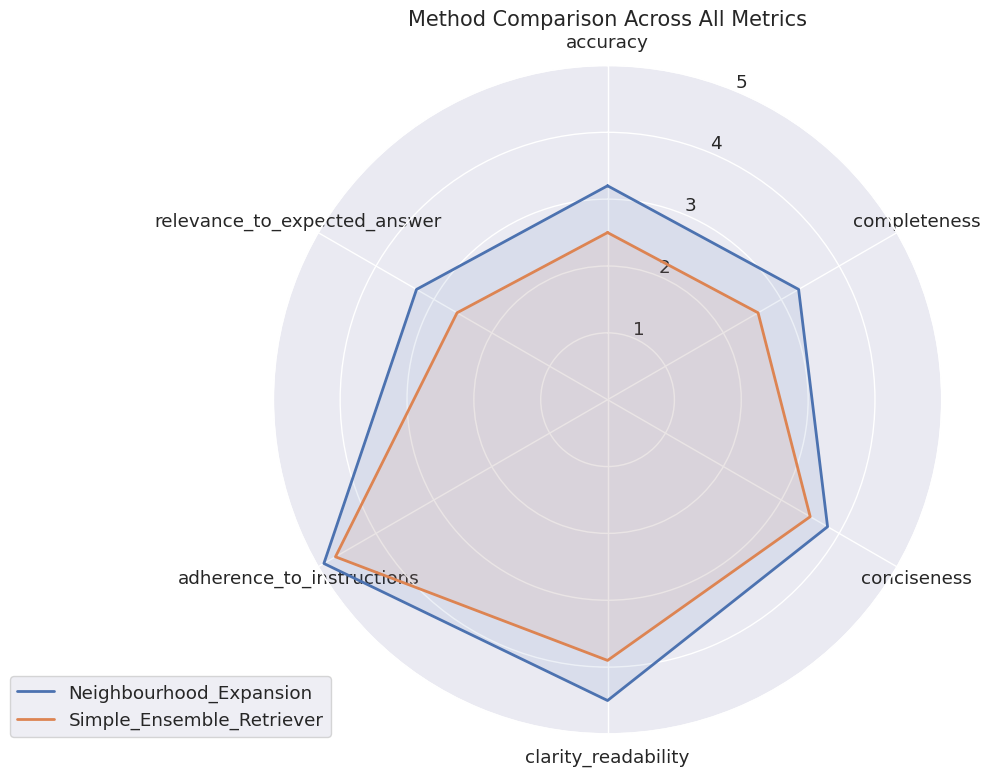

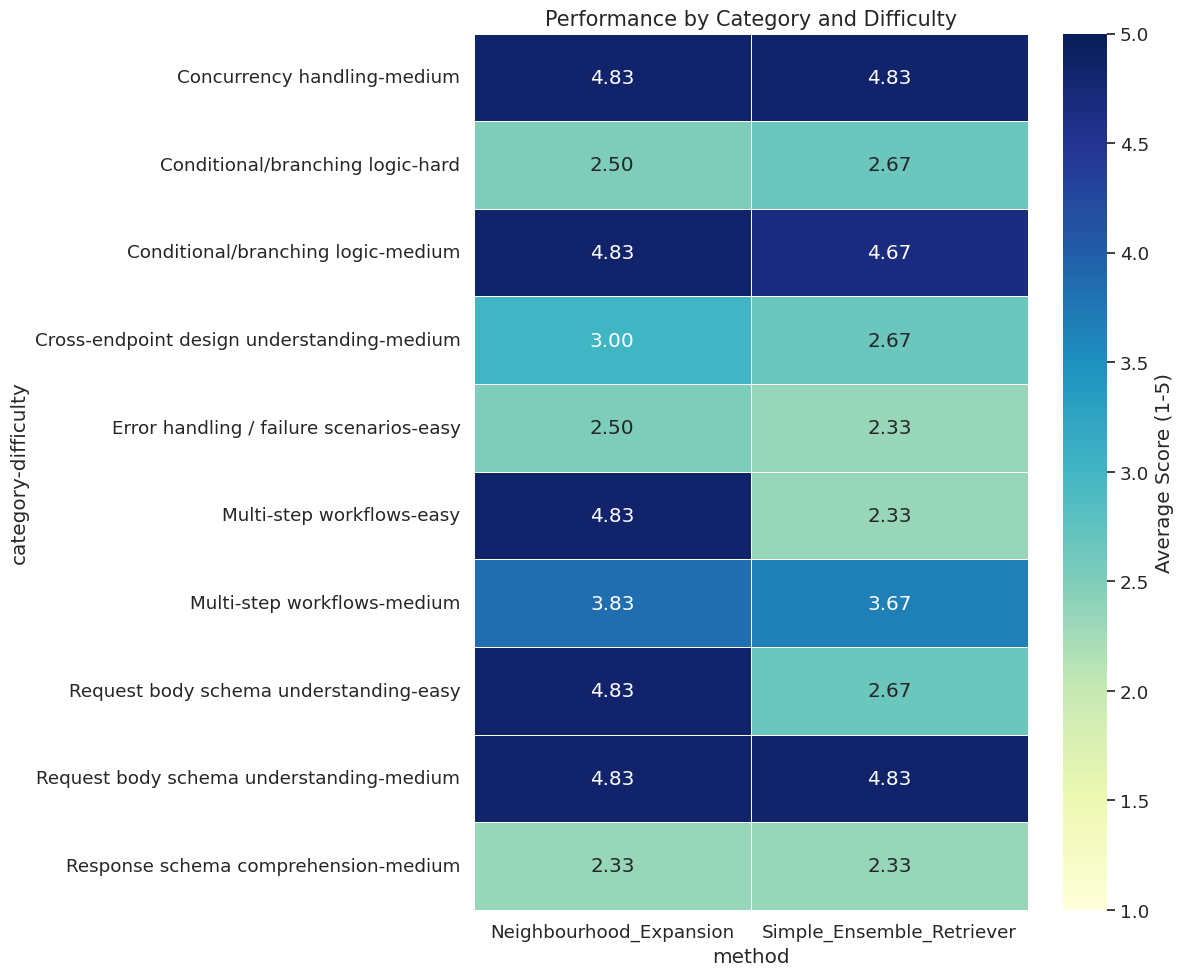

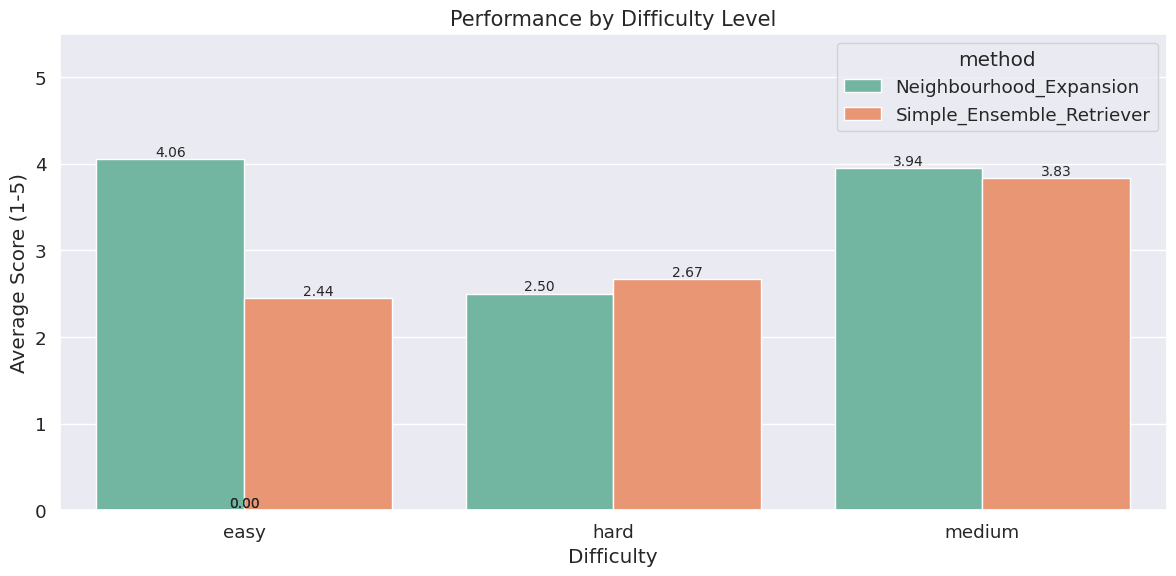

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Create a radar chart to compare methods across all metrics
def plot_radar_chart(df):
    # Get the average scores for each method and metric
    metrics = ["score_accuracy", "score_completeness", "score_conciseness", 
               "score_clarity_readability", "score_adherence_to_instructions", 
               "score_relevance_to_expected_answer"]
    
    # Calculate mean scores by method
    avg_scores = df.groupby("method")[metrics].mean().reset_index()
    
    # Set up the radar chart
    methods = avg_scores["method"].tolist()
    metric_labels = [m.replace("score_", "") for m in metrics]
    
    # Number of metrics
    N = len(metrics)
    
    # Create angles for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    
    # Add each method as a separate line
    for i, method in enumerate(methods):
        values = avg_scores.loc[avg_scores["method"] == method, metrics].values.flatten().tolist()
        values += values[:1]  # Close the loop
        
        # Plot the line
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=method)
        ax.fill(angles, values, alpha=0.1)
    
    # Fix axis to go in the right order and start at 12 o'clock
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw axis lines for each metric and label
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels)
    
    # Draw y-axis labels (0-5)
    ax.set_ylim(0, 5)
    ax.set_yticks([1, 2, 3, 4, 5])
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title('Method Comparison Across All Metrics', size=15)
    plt.tight_layout()
    plt.savefig("method_radar_comparison.png")
    plt.show()

# Call the function with your results DataFrame
plot_radar_chart(results_df)

# Create a heatmap to show performance by category and difficulty
def plot_performance_heatmap(df):
    # Calculate average overall scores (mean of all score metrics)
    score_cols = [col for col in df.columns if col.startswith('score_')]
    df['avg_score'] = df[score_cols].mean(axis=1)
    
    # Pivot to create heatmap data
    heatmap_data = df.pivot_table(
        index=['category', 'difficulty'],
        columns='method',
        values='avg_score',
        aggfunc='mean'
    )
    
    # Sort by category and difficulty
    heatmap_data = heatmap_data.sort_index(level=[0, 1])
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        heatmap_data,
        annot=True,
        cmap='YlGnBu',
        linewidths=0.5,
        fmt='.2f',
        vmin=1,
        vmax=5,
        cbar_kws={'label': 'Average Score (1-5)'}
    )
    plt.title('Performance by Category and Difficulty', size=15)
    plt.tight_layout()
    plt.savefig("category_difficulty_heatmap.png")
    plt.show()
    
    return heatmap_data

# Generate the heatmap
performance_by_category = plot_performance_heatmap(results_df)

# Create bar charts to compare methods by difficulty
def plot_difficulty_comparison(df):
    # Get average scores by method and difficulty
    difficulty_scores = df.groupby(['method', 'difficulty'])[
        [col for col in df.columns if col.startswith('score_')]
    ].mean().reset_index()
    
    # Calculate overall average score
    difficulty_scores['overall_score'] = difficulty_scores[
        [col for col in difficulty_scores.columns if col.startswith('score_')]
    ].mean(axis=1)
    
    # Plot
    plt.figure(figsize=(12, 6))
    chart = sns.barplot(
        x='difficulty',
        y='overall_score',
        hue='method',
        data=difficulty_scores,
        palette='Set2'
    )
    
    # Add value labels
    for p in chart.patches:
        chart.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            fontsize=10
        )
    
    plt.title('Performance by Difficulty Level', size=15)
    plt.xlabel('Difficulty')
    plt.ylabel('Average Score (1-5)')
    plt.ylim(0, 5.5)
    plt.tight_layout()
    plt.savefig("difficulty_comparison.png")
    plt.show()

# Generate the difficulty comparison
plot_difficulty_comparison(results_df)